# PyProb Example
This is a version of the text message example from From Chapter 1 of “Bayesian Methods for Hackers” by Cameron Davidson-Pilon rendered with pyprob


In [1]:
import pyprob
from pyprob import Model
from pyprob.distributions import Normal, Uniform, Exponential
import torch
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure();

<Figure size 432x288 with 0 Axes>

In [2]:
import csv
dat = []
with open('txtdata.csv', newline='') as File:  
    reader = csv.reader(File)
    for row in reader:
        dat.append(row[0])

In [5]:
ys = np.zeros(74)
xs = []
for i in range(74):
    ys[i] = float(dat[i+1])
    xs.append(i)
print(ys)
print(xs)
ymean = ys.mean()
print(ymean)

[13. 24.  8. 24.  7. 35. 14. 11. 15. 11. 22. 22. 11. 57. 11. 19. 29.  6.
 19. 12. 22. 12. 18. 72. 32.  9.  7. 13. 19. 23. 27. 20.  6. 17. 13. 10.
 14.  6. 16. 15.  7.  2. 15. 15. 19. 70. 49.  7. 53. 22. 21. 31. 19. 11.
 18. 20. 12. 35. 17. 23. 17.  4.  2. 31. 30. 13. 27.  0. 39. 37.  5. 14.
 13. 22.]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
19.743243243243242


In [6]:
class my_model(Model):
    def __init__(self, ymean, xmax, xs):
        super().__init__(name='my_model') # give the model a name
        self.prior_mean = ymean
        self.xmax = xmax
        self.prior_std = 1
        self.likelihood_std = 1
        self.xs = xs

    def forward(self): # Needed to specifcy how the generative model is run forward
        mu1 = pyprob.sample(Exponential(1.0/self.prior_mean ))# NOTE: sample -> denotes latent variables
        mu2 = pyprob.sample(Exponential(1.0/self.prior_mean)) # NOTE: sample -> denotes latent variables
        tau = pyprob.sample(Uniform(0,self.xmax))
        
        for i, x in enumerate(self.xs):
            if tau.numpy() > x:
                mu = mu1
            else:
                mu = mu2
            likelihood = Normal(mu, self.likelihood_std)
            pyprob.observe(likelihood, name='obs'+str(i))

        # return the latent quantity of interest
        #return mu1, mu2, tau
        return mu1, mu2 , tau
    

In [8]:
model = my_model(ymean, len(xs), xs)

In [9]:
observdic = {}
for i in range(74):
    observdic["obs"+str(i)] = ys[i]

In [10]:
posterior = model.posterior_results(
                    num_traces=10000, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.RANDOM_WALK_METROPOLIS_HASTINGS, 
                    observe= observdic )

Time spent  | Time remain.| Progress             | Trace       | Accepted|Smp reuse| Traces/sec
0d:00:01:57 | 0d:00:00:00 | #################### | 10000/10000 |   1.88% |  66.67% | 84.84       


In [11]:
print(posterior.sample())

(tensor(17.8024), tensor(23.0156), tensor(44.1014))


In [12]:
posterior_first = posterior.map(lambda v: v[0]) # extract var_0
print("mean for lambda1 =",posterior_first.mean)
posterior_second = posterior.map(lambda v: v[1]) # extract var_1
print("mean for lambda2 =",posterior_second.mean)
posterior_third = posterior.map(lambda v: v[2]) # extract var_2
print("mean for tau =",posterior_third.mean)

mean for lambda1 = tensor(17.6366)
mean for lambda2 = tensor(22.6672)
mean for tau = tensor(43.0090)


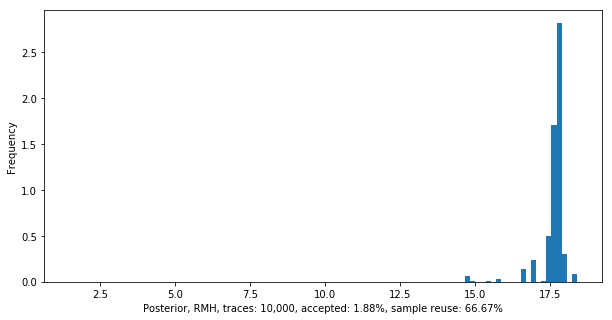

In [13]:
posterior_first.plot_histogram(show=True, bins=100)

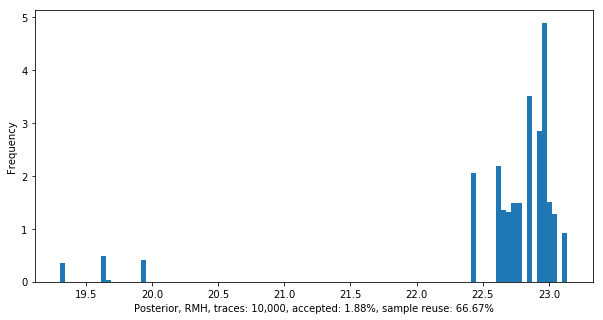

In [14]:
posterior_second.plot_histogram(show=True, bins=100)

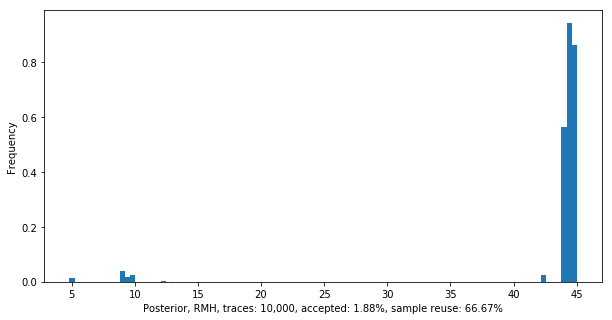

In [15]:
posterior_third.plot_histogram(show=True, bins=100)

## now test with LSTM
but we need to use a slightly different model because LSTM won't work with exponential distribution.  Instead we will use a normal distribution

In [16]:
class my_model_normal(Model):
    def __init__(self, ymean, xmax, xs):
        super().__init__(name='my_experiment') # give the model a name
        self.prior_mean = ymean
        self.xmax = xmax
        self.prior_std = 1
        self.likelihood_std = 1
        self.xs = xs

    def forward(self): # Needed to specifcy how the generative model is run forward
        # doesn't work with expnential, so use normal.
        mu1 = pyprob.sample(Normal(self.prior_mean, self.prior_std)) # NOTE: sample -> denotes latent variables
        mu2 = pyprob.sample(Normal(self.prior_mean, self.prior_std)) # NOTE: sample -> denotes latent variables
        tau = pyprob.sample(Uniform(0,self.xmax))
        
        for i, x in enumerate(self.xs):
            if tau.numpy() > x:
                mu = mu2
            else:
                mu = mu1
            likelihood = Normal(mu, self.likelihood_std)
            pyprob.observe(likelihood, name='obs'+str(i))

        # return the latent quantity of interest
        #return mu1, mu2, tau
        return mu1, mu2 , tau


In [17]:
model = my_model_normal(ymean, len(xs), xs)

In [18]:
observemb = {}
for i in range(74):
    observemb["obs"+str(i)] = {'dim' : 32}

In [19]:
model.learn_inference_network(num_traces=20000,
            observe_embeddings=observemb,
            inference_network=pyprob.InferenceNetwork.LSTM)

Creating new inference network...
Observable obs0: reshape not specified, using shape torch.Size([]).
Observable obs0: using embedding dim torch.Size([32]).
Observable obs0: observe embedding not specified, using the default FEEDFORWARD.
Observable obs0: embedding depth not specified, using the default 2.
Observable obs1: reshape not specified, using shape torch.Size([]).
Observable obs1: using embedding dim torch.Size([32]).
Observable obs1: observe embedding not specified, using the default FEEDFORWARD.
Observable obs1: embedding depth not specified, using the default 2.
Observable obs2: reshape not specified, using shape torch.Size([]).
Observable obs2: using embedding dim torch.Size([32]).
Observable obs2: observe embedding not specified, using the default FEEDFORWARD.
Observable obs2: embedding depth not specified, using the default 2.
Observable obs3: reshape not specified, using shape torch.Size([]).
Observable obs3: using embedding dim torch.Size([32]).
Observable obs3: observe

Observable obs59: reshape not specified, using shape torch.Size([]).
Observable obs59: using embedding dim torch.Size([32]).
Observable obs59: observe embedding not specified, using the default FEEDFORWARD.
Observable obs59: embedding depth not specified, using the default 2.
Observable obs60: reshape not specified, using shape torch.Size([]).
Observable obs60: using embedding dim torch.Size([32]).
Observable obs60: observe embedding not specified, using the default FEEDFORWARD.
Observable obs60: embedding depth not specified, using the default 2.
Observable obs61: reshape not specified, using shape torch.Size([]).
Observable obs61: using embedding dim torch.Size([32]).
Observable obs61: observe embedding not specified, using the default FEEDFORWARD.
Observable obs61: embedding depth not specified, using the default 2.
Observable obs62: reshape not specified, using shape torch.Size([]).
Observable obs62: using embedding dim torch.Size([32]).
Observable obs62: observe embedding not spec

0d:00:02:56 | 1    | 7,232     | +7.03e+00 | +6.87e+00 | +7.03e+00 | 0d:00:00:00 | +1.00e-03 | 69.5 +7.03e+00 | +7.44e+00 | 0d:00:00:00 | +1.00e-03 | 46.2 +7.28e+00 | 0d:00:00:02 | +1.00e-03 | 45.7                               +7.13e+00 | 0d:00:00:04 | +1.00e-03 | 49.7                               +7.03e+00 | +7.03e+00 | 0d:00:00:00 | +1.00e-03 | 44.7 +7.03e+00 | 0d:00:00:01 | +1.00e-03 | 42.7                               +7.23e+00 | 0d:00:00:03 | +1.00e-03 | 33.8                               +7.07e+00 | 0d:00:00:05 | +1.00e-03 | 31.5                               +7.12e+00 | 0d:00:00:07 | +1.00e-03 | 29.8                               +7.06e+00 | 0d:00:00:09 | +1.00e-03 | 37.4                               +7.08e+00 | 0d:00:00:11 | +1.00e-03 | 37.1                               +7.06e+00 | 0d:00:00:12 | +1.00e-03 | 43.2                               +7.17e+00 | 0d:00:00:13 | +1.00e-03 | 44.1                               +7.37e+00 | 0d:00:00:15 | +1.00e-03 | 47.1                  

0d:00:07:57 | 1    | 19,968    | +7.03e+00 | +6.72e+00 | +7.13e+00 | 0d:00:02:28 | +1.00e-03 | 49.4                               +7.46e+00 | 0d:00:02:29 | +1.00e-03 | 42.5                               +7.07e+00 | 0d:00:02:31 | +1.00e-03 | 49.7                               +7.08e+00 | 0d:00:02:32 | +1.00e-03 | 47.0                               +7.12e+00 | 0d:00:02:33 | +1.00e-03 | 48.4                               +6.99e+00 | 0d:00:02:35 | +1.00e-03 | 37.1                               +7.17e+00 | 0d:00:02:37 | +1.00e-03 | 35.8                               +7.15e+00 | 0d:00:02:39 | +1.00e-03 | 34.9                               +7.28e+00 | 0d:00:02:40 | +1.00e-03 | 40.2                               +7.07e+00 | 0d:00:02:42 | +1.00e-03 | 47.7                               +7.09e+00 | 0d:00:02:43 | +1.00e-03 | 45.7                               +7.45e+00 | 0d:00:02:44 | +1.00e-03 | 47.0                               +7.17e+00 | 0d:00:02:46 | +1.00e-03 | 43.5                         

In [20]:
posterior = model.posterior_results(
                num_traces=10000, # the number of samples estimating the posterior
                inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, 
                observe= observdic )

Time spent  | Time remain.| Progress             | Trace       | Traces/sec
0d:00:05:45 | 0d:00:00:00 | #################### | 10000/10000 | 28.97       


In [21]:
print(posterior.sample())

(tensor(22.0710), tensor(18.4651), tensor(43.4458))


In [22]:
posterior.mean

tensor([22.0705, 18.4650, 43.4460])

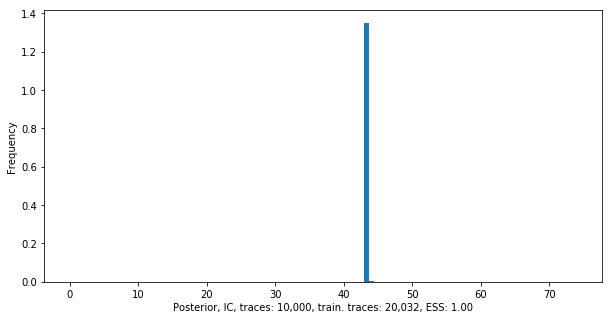

In [23]:
posterior_first = posterior.map(lambda v: v[2]) # extract var_0
var_0_mean = posterior_first.mean
posterior_first.plot_histogram(show=True, bins=100)

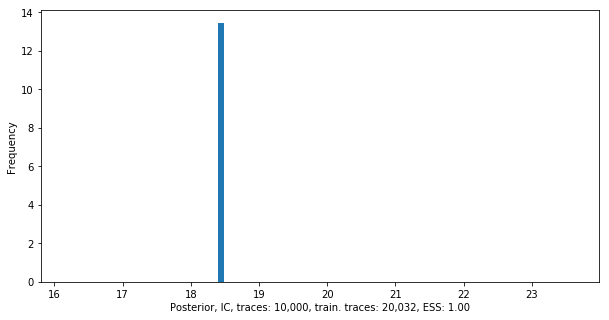

In [24]:
posterior_first = posterior.map(lambda v: v[1]) # extract var_0
var_0_mean = posterior_first.mean
posterior_first.plot_histogram(show=True, bins=100)

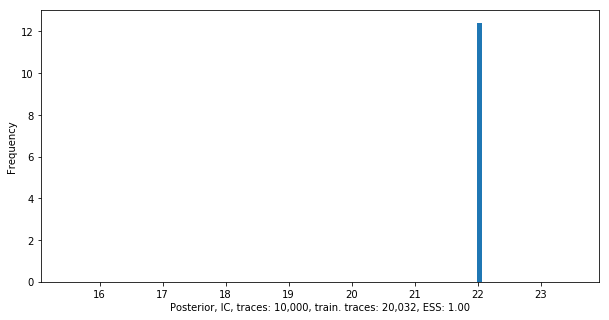

In [25]:
posterior_first = posterior.map(lambda v: v[0]) # extract var_0
var_0_mean = posterior_first.mean
posterior_first.plot_histogram(show=True, bins=100)